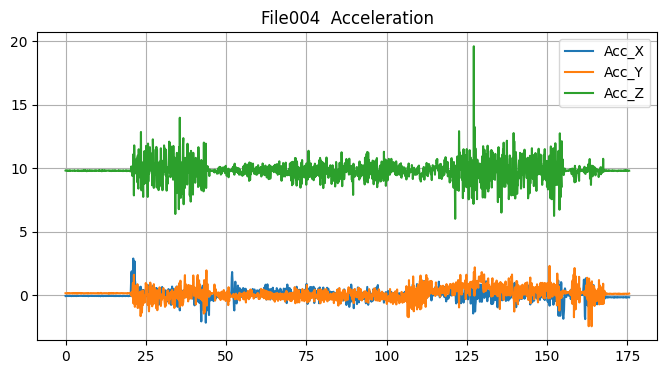

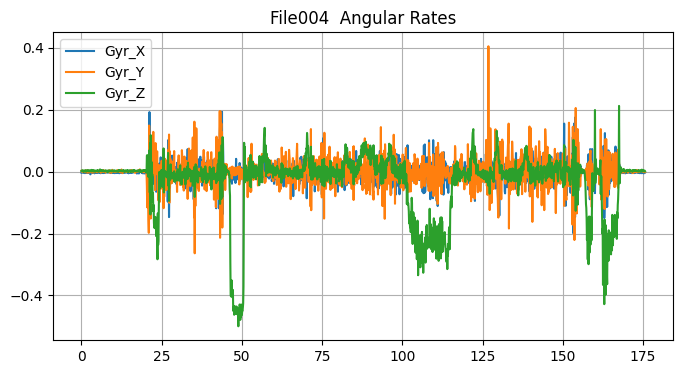

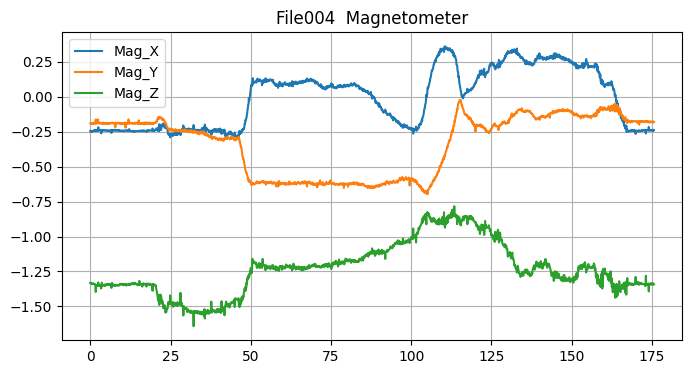

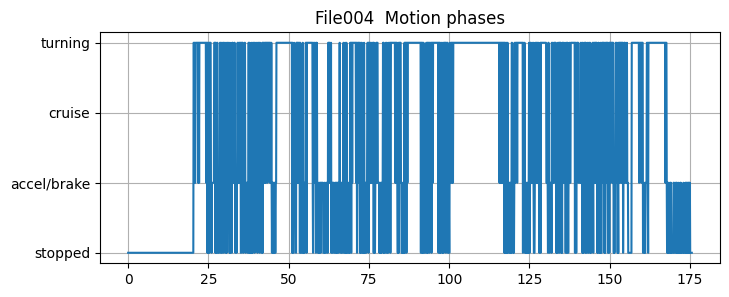

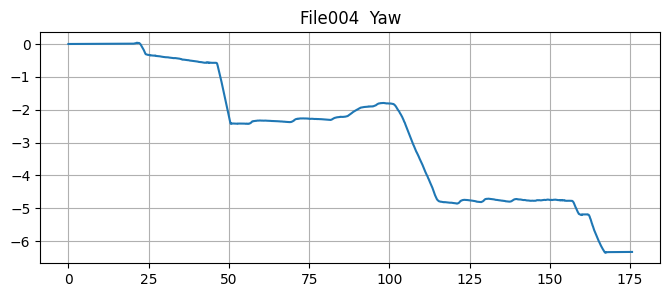

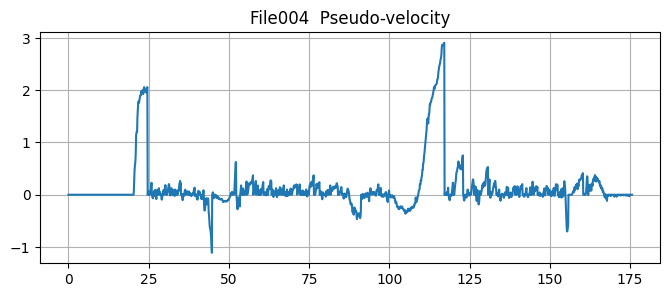

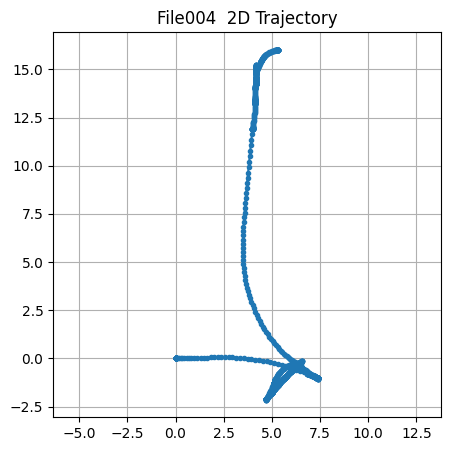

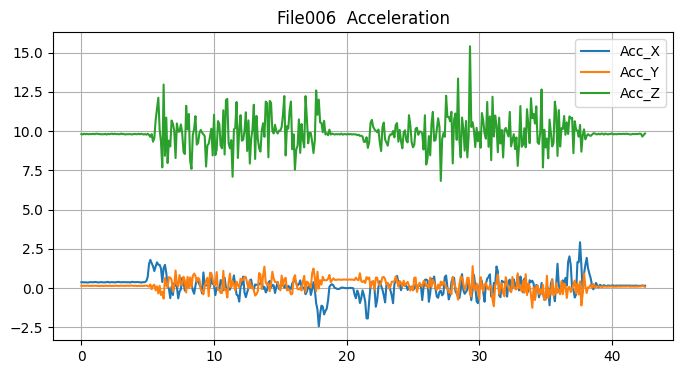

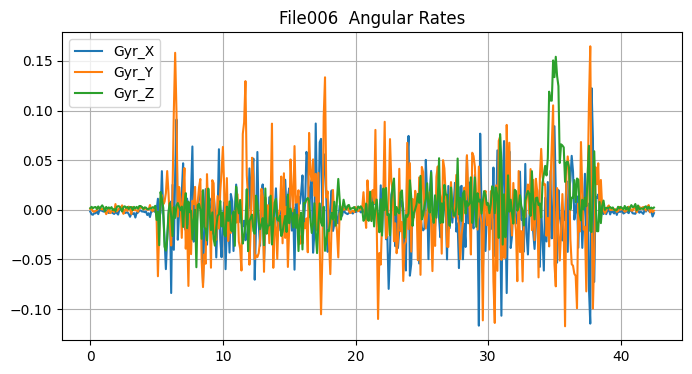

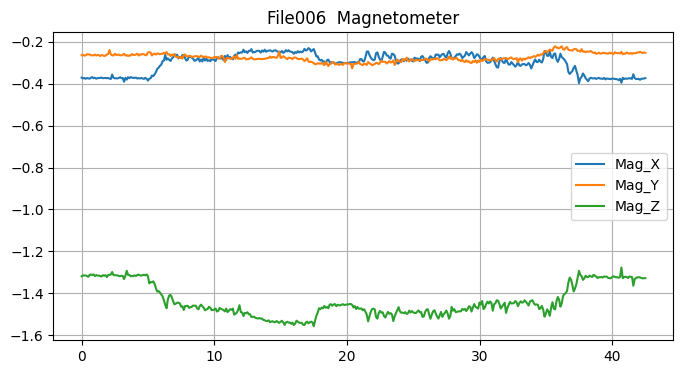

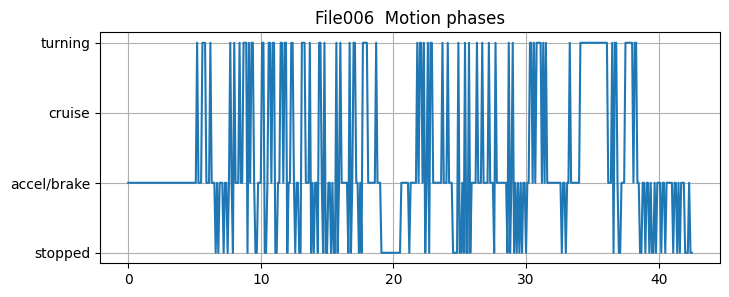

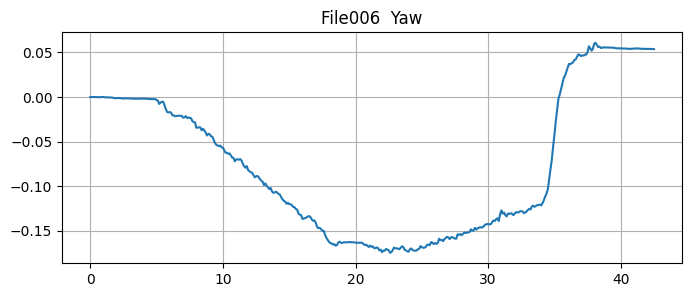

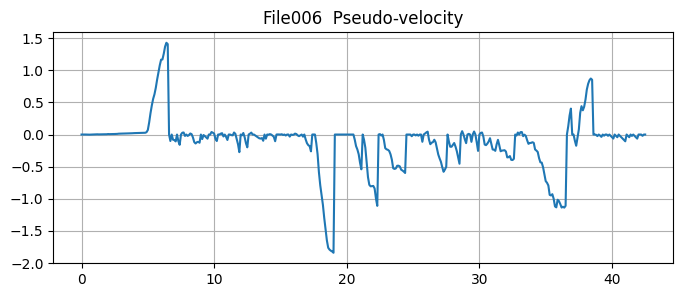

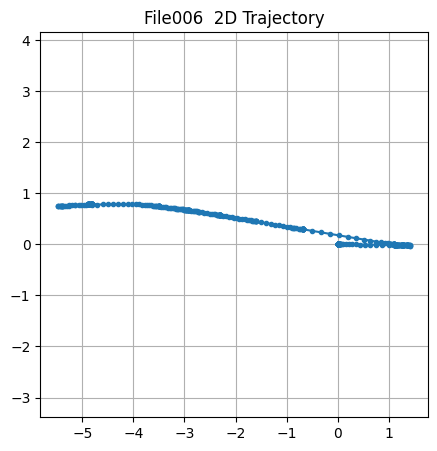

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# 1. Helper functions
# -----------------------------------------------------------

def load_imu_file(path):
    df = pd.read_csv(path, comment='/', sep=',')
    t0 = df['SampleTimeFine'].iloc[0]
    df['t'] = (df['SampleTimeFine'] - t0) * 1e-4
    return df

def estimate_sampling_time(df):
    dt_ticks = df['SampleTimeFine'].diff().dropna().mode()[0]
    dt = dt_ticks * 1e-4
    return dt

def simple_motion_phase(df, acc_col='Acc_X', gyr_col='Gyr_Z',
                        acc_thresh=0.15, gyr_thresh=0.02):
    ax = df[acc_col].values
    gz = df[gyr_col].values

    phases = []
    for a, g in zip(ax, gz):
        if abs(a) < acc_thresh and abs(g) < gyr_thresh:
            phases.append('stopped')
        elif abs(g) > gyr_thresh:
            phases.append('turning')
        elif abs(a) > acc_thresh:
            phases.append('accel/brake')
        else:
            phases.append('cruise')
    return np.array(phases)

def integrate_gyro_to_yaw(df, gyr_col='Gyr_Z'):
    dt = estimate_sampling_time(df)
    gz = df[gyr_col].values
    n_bias = max(1, int(1.0 / dt))
    bias = np.mean(gz[:n_bias])
    gz_corr = gz - bias
    yaw = np.cumsum(gz_corr) * dt
    return yaw

def integrate_acc_to_velocity(df, acc_col='Acc_X', phases=None):
    dt = estimate_sampling_time(df)
    a = df[acc_col].values
    n_bias = max(1, int(1.0 / dt))
    bias = np.mean(a[:n_bias])
    a_corr = a - bias

    v = np.zeros_like(a_corr)
    for i in range(1, len(a_corr)):
        v[i] = v[i-1] + a_corr[i] * dt
        if phases is not None and phases[i] == 'stopped':
            v[i] = 0.0
    return v

def integrate_to_xy(v, yaw, df):
    dt = estimate_sampling_time(df)
    x = np.zeros_like(v)
    y = np.zeros_like(v)
    for i in range(1, len(v)):
        x[i] = x[i-1] + v[i] * np.cos(yaw[i]) * dt
        y[i] = y[i-1] + v[i] * np.sin(yaw[i]) * dt
    return x, y

def plot_all_signals(df, title_prefix=""):
    t = df['t'].values
    plt.figure(figsize=(8,4))
    plt.plot(t, df['Acc_X'], label='Acc_X')
    plt.plot(t, df['Acc_Y'], label='Acc_Y')
    plt.plot(t, df['Acc_Z'], label='Acc_Z')
    plt.legend(); plt.grid(); plt.title(title_prefix+" Acceleration")

    plt.figure(figsize=(8,4))
    plt.plot(t, df['Gyr_X'], label='Gyr_X')
    plt.plot(t, df['Gyr_Y'], label='Gyr_Y')
    plt.plot(t, df['Gyr_Z'], label='Gyr_Z')
    plt.legend(); plt.grid(); plt.title(title_prefix+" Angular Rates")

    plt.figure(figsize=(8,4))
    plt.plot(t, df['Mag_X'], label='Mag_X')
    plt.plot(t, df['Mag_Y'], label='Mag_Y')
    plt.plot(t, df['Mag_Z'], label='Mag_Z')
    plt.legend(); plt.grid(); plt.title(title_prefix+" Magnetometer")

def plot_motion_results(df, phases, yaw, v, x, y, title_prefix=""):
    t = df['t'].values
    phase_map = {'stopped':0, 'accel/brake':1, 'cruise':2, 'turning':3}
    phase_vals = np.array([phase_map[p] for p in phases])

    plt.figure(figsize=(8,3))
    plt.plot(t, phase_vals)
    plt.yticks(list(phase_map.values()), list(phase_map.keys()))
    plt.grid(); plt.title(title_prefix+" Motion phases")

    plt.figure(figsize=(8,3))
    plt.plot(t, yaw)
    plt.grid(); plt.title(title_prefix+" Yaw")

    plt.figure(figsize=(8,3))
    plt.plot(t, v)
    plt.grid(); plt.title(title_prefix+" Pseudo-velocity")

    plt.figure(figsize=(5,5))
    plt.plot(x, y, marker='.')
    plt.axis('equal'); plt.grid()
    plt.title(title_prefix+" 2D Trajectory")

# IMU Motion Reconstruction
Each subsequent cell renders a single plot. First, File004 plots; then, File006 plots.

In [2]:
# File004: load and compute derived signals
df1 = load_imu_file("MT_0080001528_004-000.txt")
phases1 = simple_motion_phase(df1)
yaw1 = integrate_gyro_to_yaw(df1)
v1 = integrate_acc_to_velocity(df1, phases=phases1)
x1, y1 = integrate_to_xy(v1, yaw1, df1)

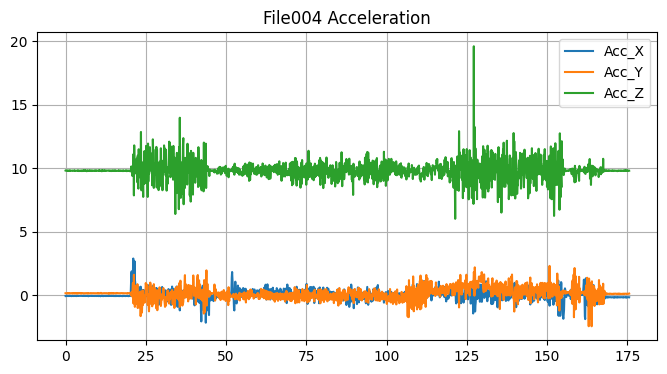

In [3]:
# File004: Acceleration
t = df1['t'].values
plt.figure(figsize=(8,4))
plt.plot(t, df1['Acc_X'], label='Acc_X')
plt.plot(t, df1['Acc_Y'], label='Acc_Y')
plt.plot(t, df1['Acc_Z'], label='Acc_Z')
plt.legend(); plt.grid(); plt.title("File004 Acceleration")
plt.show()

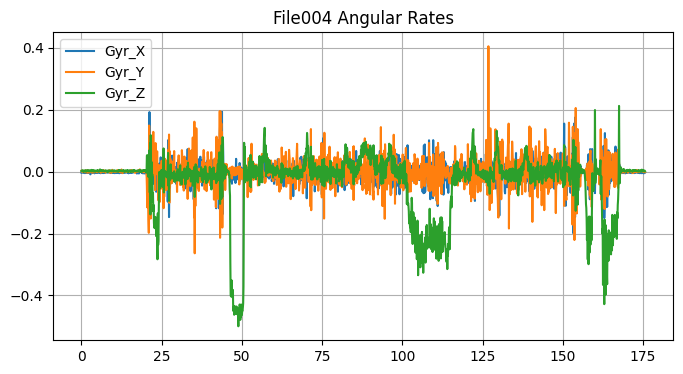

In [4]:
# File004: Angular Rates
t = df1['t'].values
plt.figure(figsize=(8,4))
plt.plot(t, df1['Gyr_X'], label='Gyr_X')
plt.plot(t, df1['Gyr_Y'], label='Gyr_Y')
plt.plot(t, df1['Gyr_Z'], label='Gyr_Z')
plt.legend(); plt.grid(); plt.title("File004 Angular Rates")
plt.show()

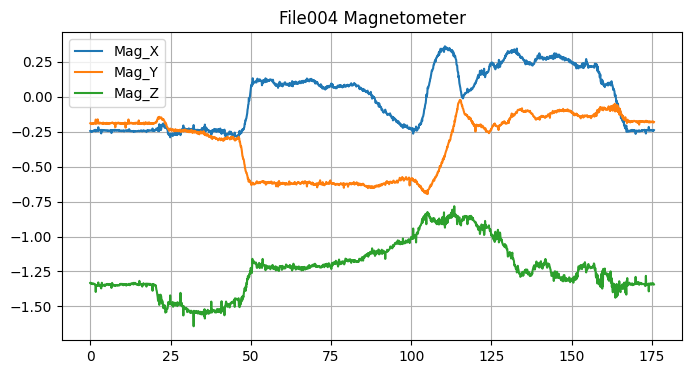

In [5]:
# File004: Magnetometer
t = df1['t'].values
plt.figure(figsize=(8,4))
plt.plot(t, df1['Mag_X'], label='Mag_X')
plt.plot(t, df1['Mag_Y'], label='Mag_Y')
plt.plot(t, df1['Mag_Z'], label='Mag_Z')
plt.legend(); plt.grid(); plt.title("File004 Magnetometer")
plt.show()

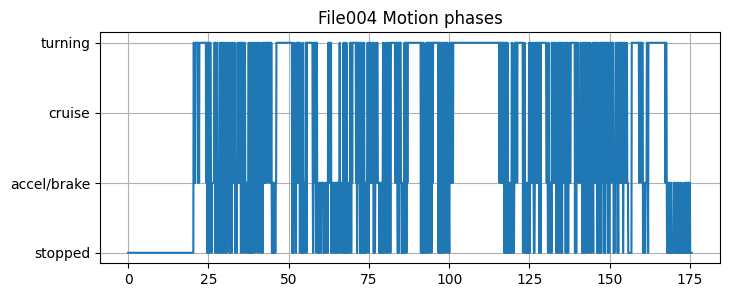

In [6]:
# File004: Motion phases
t = df1['t'].values
phase_map = {'stopped':0, 'accel/brake':1, 'cruise':2, 'turning':3}
phase_vals = np.array([phase_map[p] for p in phases1])
plt.figure(figsize=(8,3))
plt.plot(t, phase_vals)
plt.yticks(list(phase_map.values()), list(phase_map.keys()))
plt.grid(); plt.title("File004 Motion phases")
plt.show()

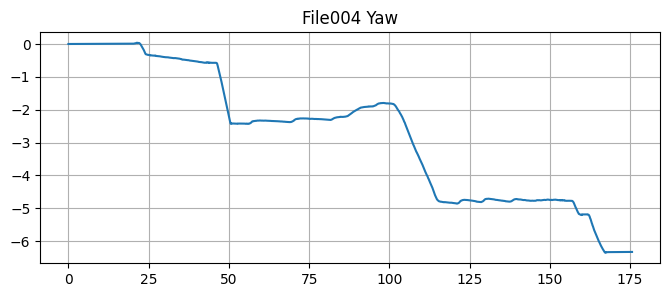

In [7]:
# File004: Yaw
t = df1['t'].values
plt.figure(figsize=(8,3))
plt.plot(t, yaw1)
plt.grid(); plt.title("File004 Yaw")
plt.show()

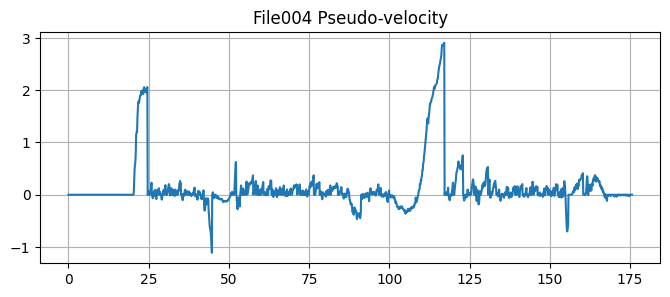

In [8]:
# File004: Pseudo-velocity
t = df1['t'].values
plt.figure(figsize=(8,3))
plt.plot(t, v1)
plt.grid(); plt.title("File004 Pseudo-velocity")
plt.show()

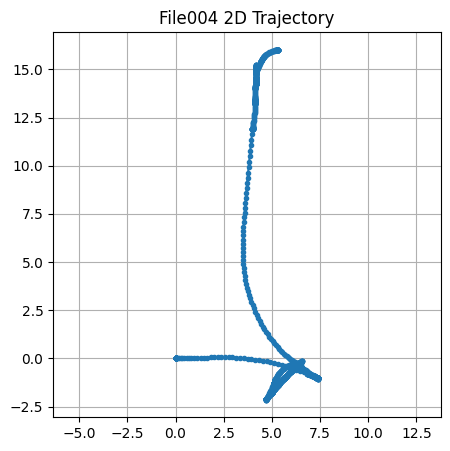

In [9]:
# File004: 2D Trajectory
plt.figure(figsize=(5,5))
plt.plot(x1, y1, marker='.')
plt.axis('equal'); plt.grid()
plt.title("File004 2D Trajectory")
plt.show()

In [17]:
# File006: load and compute derived signals
df2 = load_imu_file("MT_0080001528_006-000.txt")
phases2 = simple_motion_phase(df2)
yaw2 = integrate_gyro_to_yaw(df2)
v2 = integrate_acc_to_velocity(df2, phases=phases2)
x2, y2 = integrate_to_xy(v2, yaw2, df2)

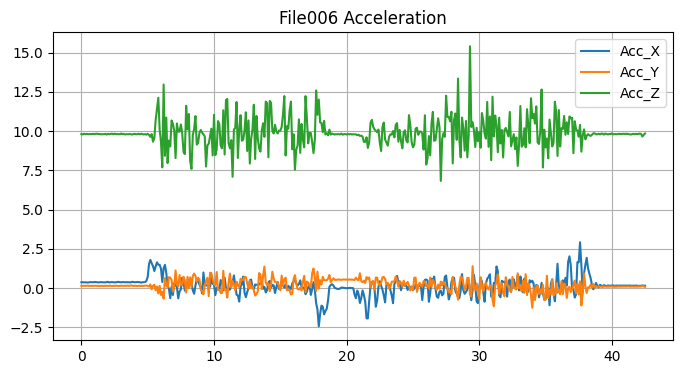

In [16]:
# File006: Acceleration
t = df2['t'].values
plt.figure(figsize=(8,4))
plt.plot(t, df2['Acc_X'], label='Acc_X')
plt.plot(t, df2['Acc_Y'], label='Acc_Y')
plt.plot(t, df2['Acc_Z'], label='Acc_Z')
plt.legend(); plt.grid(); plt.title("File006 Acceleration")
plt.show()

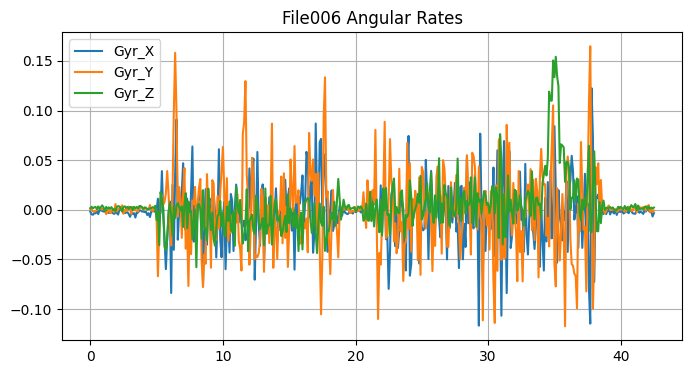

In [15]:
# File006: Angular Rates
t = df2['t'].values
plt.figure(figsize=(8,4))
plt.plot(t, df2['Gyr_X'], label='Gyr_X')
plt.plot(t, df2['Gyr_Y'], label='Gyr_Y')
plt.plot(t, df2['Gyr_Z'], label='Gyr_Z')
plt.legend(); plt.grid(); plt.title("File006 Angular Rates")
plt.show()

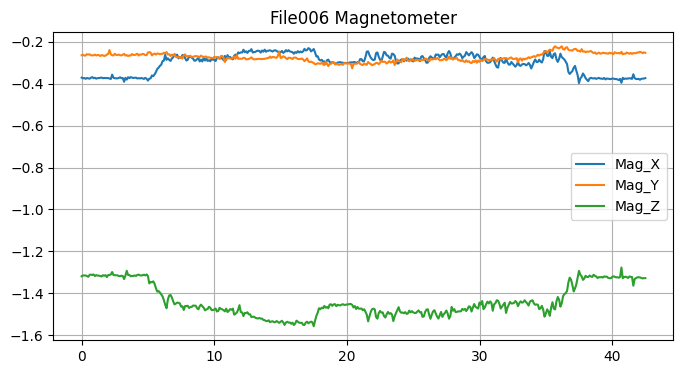

In [14]:
# File006: Magnetometer
t = df2['t'].values
plt.figure(figsize=(8,4))
plt.plot(t, df2['Mag_X'], label='Mag_X')
plt.plot(t, df2['Mag_Y'], label='Mag_Y')
plt.plot(t, df2['Mag_Z'], label='Mag_Z')
plt.legend(); plt.grid(); plt.title("File006 Magnetometer")
plt.show()

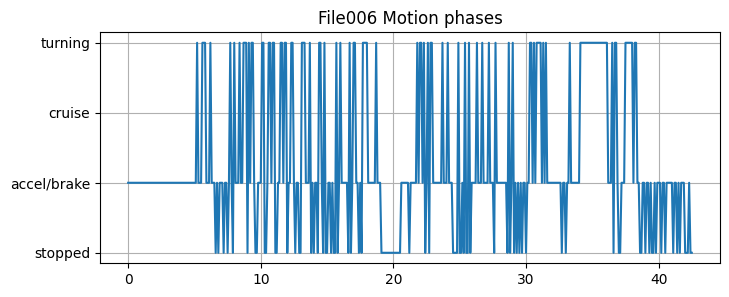

In [13]:
# File006: Motion phases
t = df2['t'].values
phase_map = {'stopped':0, 'accel/brake':1, 'cruise':2, 'turning':3}
phase_vals = np.array([phase_map[p] for p in phases2])
plt.figure(figsize=(8,3))
plt.plot(t, phase_vals)
plt.yticks(list(phase_map.values()), list(phase_map.keys()))
plt.grid(); plt.title("File006 Motion phases")
plt.show()

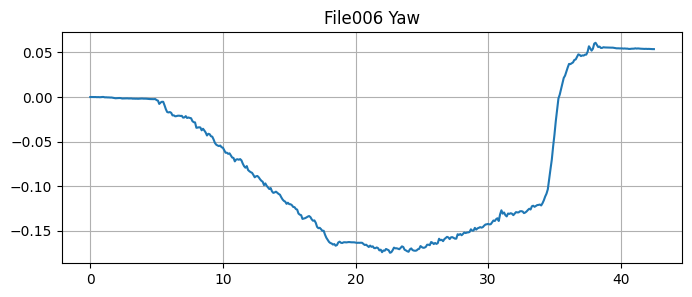

In [12]:
# File006: Yaw
t = df2['t'].values
plt.figure(figsize=(8,3))
plt.plot(t, yaw2)
plt.grid(); plt.title("File006 Yaw")
plt.show()

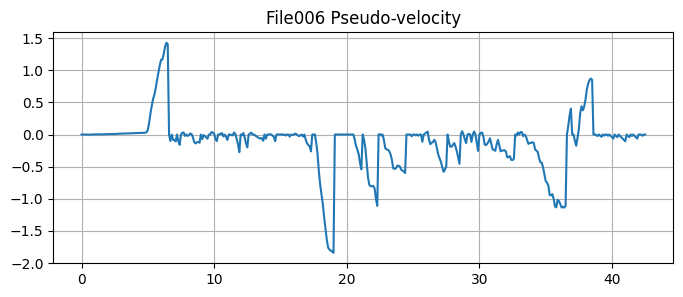

In [11]:
# File006: Pseudo-velocity
t = df2['t'].values
plt.figure(figsize=(8,3))
plt.plot(t, v2)
plt.grid(); plt.title("File006 Pseudo-velocity")
plt.show()

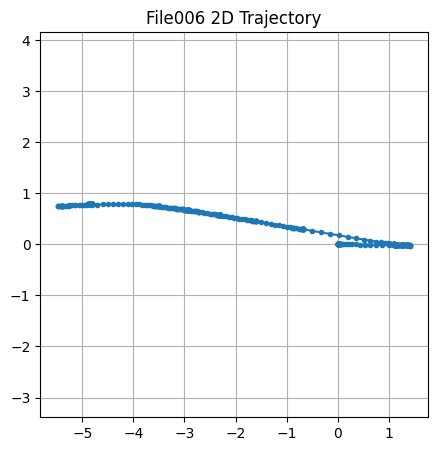

In [10]:
# File006: 2D Trajectory
plt.figure(figsize=(5,5))
plt.plot(x2, y2, marker='.')
plt.axis('equal'); plt.grid()
plt.title("File006 2D Trajectory")
plt.show()